# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v9 code (OR def) is a final, cleaned and commented version.
This version, wrt to v8, implements an hourly ET0 calculated with hourly FAO-56 Penman-Monteith and a SWB model that is properly corrected for hourly calculation of the evapotranspiration.
Kc curves are also externally defined in a module of their own.

# Dependencies

In [141]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
from modules.funcs_plot import *
from modules.funcs_analysis import *
from modules.IRRI_WCM_model import *
from modules.Kc_curve import Kc_curve
from modules.EPOT_Hargreaves_pyeto import *

from scipy.signal import savgol_filter

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

In [142]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = False
year = 2017 # int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))
freq = 'h' # input('Daily or hourly frequency? [d/h]')

print('\n#-------------WCM model parameters-------------')
units = 'lin' # input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

print('\n#------------Optimization parameters-----------')
opt_calib = '1' # input('Cost function (KGE) on sigma0 (1) or sigma0 and soil moisture (2)? [1/2]')
opt_cost = 'KGE'

PAR_str_add = '_' + str(year) + input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

# check if params are already present
# if len(params)>0: opt_params = input('Params already present: overwrite [y] or append [n]? [y/n]')
# if opt_params=='y': params = []

Starting...
#-------------------------------------------------------------


#-------------SWB model parameters-------------

#-------------WCM model parameters-------------

#------------Optimization parameters-----------


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [143]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('..\Inputs\Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

In [144]:
#----------------------------------------------------------------------------
# Budrio field data from meteo tables

# Freq: H
# Data extracted:
# none
# Needed for eto from FAO PM 

meteo_df = pd.ExcelFile('..\Inputs\Budrio_Meteo.xlsx', engine='openpyxl')
meteo_df = meteo_df.parse(str(year))
# meteo_df = pd.concat([meteo_df.parse('2017'), meteo_df.parse('2020')]).set_index('ID')

# Column 'Date' contains date+hour = hourly information
meteo_df['Datetime'] = meteo_df.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
meteo_df = meteo_df.set_index('Datetime')
meteo_df = meteo_df.drop(['Data', 'Ora'],axis=1)

if verbose: meteo_df.info()
# meteo_df.head()

In [145]:
# Budrio database
# Freq: H
# Merging of Platinum+Meteo

meteo_h = pd.merge(right=platinum_df, left=meteo_df, on='Datetime')
if verbose: meteo_h.info()

In [146]:
lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

In [147]:
# Computation of hourly eto by hourly FAO Penman-Monteith equation
# FAO-56 pag. 74

t = [x for x in meteo_h.index if x.year==year]

# Inputs
# ------
RH = meteo_h.loc[t]['Umidità aria Netsens [%] '].values if year==2017 else meteo_h.loc[t]['Umidità aria [%] '].values # mean hourly relative humidity [%]
T = meteo_h.loc[t]['Temperatura[°C]'].values # mean hourly air temperature [°C]
sol_rad = meteo_h.loc[t]['Radiazione solare [W/m2]  '].values # measured solar radiation [J m^-2 s^-1]
sol_rad_hour = sol_rad*3600*1e-6 # [MJ m^-2 h^-1]
T_dew = meteo_h.loc[t]['Punto di rugiada [C°] '].values # dew point [°C]
atmos_pres = meteo_h.loc[t]['Pressione atmosferica [hPa]  '].values/10 # atmospheric pressure [kPa]
wind_s = meteo_h.loc[t]['Velocità del vento [m/s]'].values
epot_hourly = [0.]*len(t)

# Params
# ------
for i in range(len(t)):
    
    lat_deg = 44.570842547510622 # latitude of Budrio (deg)
    lat_rad = np.deg2rad(lat_deg)
    long_deg = 11.53267200001359 # longitude of Budrio (deg)
    long_rad = np.deg2rad(long_deg)
    altitude = 11. # elevation [m]
    doy = t[i].dayofyear
    hour = t[i].hour
    mid_hour = hour+0.5
    
    # Extraterrestrial radiation (et_rad)
    Gsc = 0.0820 # MJ m^-2 min^-1
    dr = inv_rel_dist_earth_sun(doy) # inverse relative distance Earth-Sun
    d = sol_dec(doy) # solar declination [rad]
    phi = lat_rad # latitude [rad]
    lz = 360-15 # longitude of centre of local time zone (CET) (deg W of Greenwhich)
    lm = 360-long_deg # longitude of site (deg W of Greenwhich)
    b = 2*np.pi*(doy-81)/364
    Sc = 0.1645*np.sin(2*b)-0.1255*np.cos(b)-0.025*np.sin(b) # seasonal correction for solar time
    w = np.pi/12*((mid_hour+0.006667*(lz-lm)+Sc)-12) # solar time angle at midpoint of the period
    w1 = w-np.pi/24 # solar time angle at beginning [rad]
    w2 = w+np.pi/24 # solar time angle at end [rad]

    
    et_rad = 12*60/np.pi*Gsc*dr*((w2-w1)*np.sin(phi)*np.sin(d)+np.cos(phi)*np.cos(d)*(np.sin(w2)-np.sin(w1)))
    
    ws = np.arccos(-np.tan(lat_rad)*np.tan(d))
    N = 24/np.pi*ws # daylight hours
    Rs = sol_rad_hour[i] # measured solar radiation [MJ m^-2 h^-1]
    Rso = cs_rad(altitude, et_rad) # clear sky radiation [MJ m^-2 h^-1]
                                 
    avp = avp_from_tdew(T_dew[i]) # actual vapour pressure
    ni_rad = net_in_sol_rad(Rs) # net incoming solar radiation # use this formula, albedo is default value
                                 
    boltz_h = 2.043*1e-10 # Boltzmann constant [MJ m^-2 h^-1]
    e_thr = svp_from_t(T[i]) # saturation vapour pressure
    e_a = e_thr*RH[i]/100# average hourly actual vapour pressure
    Rs_ratio = Rs/Rso if Rs/Rso<1 else 1
    no_rad = boltz_h*T[i]**4*(0.34-0.14*np.sqrt(e_a))*(1.35*Rs_ratio-0.35) # net outgoing radiation corrected for hourly period
    R_n = ni_rad - no_rad # net radiation at grass surface
    
    u2 = wind_s[i]
    G = 0.1*R_n if hour in range(6,18,1) else 0.5*R_n # soil heat flux density, ref. eq. 45, 46 FAO56
    Delta = delta_svp(T[i]) #saturation slope
    gamma = psy_const(atmos_pres[i])# psychrometric constant
    
    epot_hourly[i] = (0.408*Delta*(R_n-G)+gamma*37/(T[i]+273)*u2*(e_thr-e_a))/(Delta+gamma*(1+0.34*u2))

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $\theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [148]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('..\Data\\budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
angle_mean_95 = sigma_df.loc[sigma_df.Orb==95]['Angle[°]'].mean()
sigma_df['Angle[°]'] = sigma_df['Angle[°]'].apply(lambda x : angle_mean_95)
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

In [149]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('..\Data\\budrio-half_NDVI_discrete.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
ndvi_df = ndvi_df.resample('H').asfreq().interpolate(method='linear')
if verbose: ndvi_df.info()

# Input data

In [150]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

if freq=='d':
    input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)
    input_swb['SWC[m3/m3]'] = platinum_resampled.mean()['SWC[m3/m3]']
    if verbose: input_swb.info()

# Input SWB
# Frequency: hourly
# Data:
# - rain (hourly) from platinum_df, linear interpolation
# - irrigation (hourly) from platinum_df
# - eto (daily) from eto_df, up-resampled hourly with linear interpolation

elif freq=='h':
    # eto_df_h = eto_df.resample('H').asfreq().interpolate(method='linear')
    eto_df_h = pd.DataFrame(timeseries(t, epot_hourly)).rename(columns={0:'Datetime', 1:'EPOT'})
    eto_df_h.set_index('Datetime')
    input_swb = pd.merge(right=eto_df_h, left=platinum_df,
                         on='Datetime',)\
                        .drop(['Temperatura[°C]'], axis=1)
    input_swb.set_index('Datetime', inplace=True)
    input_swb['Pioggia[mm]'].interpolate(method='linear',inplace=True)
    input_swb['EPOT'].interpolate(method='linear',inplace=True)
    if verbose: input_swb.info()

In [151]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   0 non-null      object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [152]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)
if freq=='d': input_wcm.index = input_wcm.Datetime.round('D')
elif freq=='h': input_wcm.index = input_wcm.Datetime
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.


In [153]:
# List of 2017 and 2020 dates

# Complete hours in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
     
# Hours of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [154]:
P       = input_swb.loc[t]['Pioggia[mm]'].values # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'].values # [mm]
EPOT    = input_swb.loc[t]['EPOT'].values # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'].values # daily mean or hourly, with gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'].values # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'].values # [-]
angle   = input_wcm.loc[t_sat]['Angle'].values # [°]
VV      = input_wcm.loc[t_sat]['VV'].values # [dB]
VH      = input_wcm.loc[t_sat]['VH'].values # [dB]
CR      = input_wcm.loc[t_sat]['CR'].values # [-]
Kc_array= Kc_curve(year, t)

# Calibration SWB+WCM

In [155]:
def IRR_WCM(PAR, inputs, user_in):
    """Irrigation model and WCM integration.

    Based on minimization of KGE between observed and simulated
    $\sigma^0$ values via PSO (pyswarm) optimization.
    The soil water balance model (IRR) produces an estimate of the soil water
    content WW [%] that is used to simulate $\sigma^0$ by a water cloud
    model (WCM).

    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [A, B, C, D, W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs: input quantities for calibration,
        [d, d_sat, P, IRR_obs, EPOT, WWobs, LAI, t_deg, obs]
    - user_in: user-defined options
        irri = user_in: if user_in=True, irrigation is estimated
        and not taken as an input, else the input observed irrigation
        is used in the soil water balance

    Return
    -------
    KGE from hydroeval between sigma0 observed and simulated.

    """

    # User input
    irri, units = user_in

    # Unpack inputs
    A, B, C, D, WW_fc, WW_w, Kc0 = PAR
    t, t_sat, P, IRR_obs, EPOT, Kc, WW_obs, WW_sat, veg, angle, sig0_obs, freq, rho_st = inputs

    angle_m = np.mean(angle)
    Ks      = 0. # water stress coefficient
    rho     = 0. # depletion fraction
    WW      = np.array([.2]*len(t), dtype=float) # water content [m3/m3]
    WW[0]   = WW_obs[0] # initial value of sm [m3/m3]
    depth   = 30 # dynamic depth [mm]

    COST   = .0   # additional cost to KGE
    LAMBDA = 1000 # Lagrange multiplier

    for i in [i+1 for i in range(len(t)-1)]:

        # Compute DoI of W[i-1]
        depth = doi(freq=freq,
                    sand=45, clay=15,
                    water=WW[i-1],
                    angle=angle_m)\
                    *1000\
                    # *W_max\
            # *1000 is to account for going from [m] to [mm]

        # Build Ks curve
        # Compute crop coeff and depletion fraction
        rho=rho_st+0.04*(5-Kc[i]*Kc0*EPOT[i]*24)
        if   rho<0.1: COST += (rho-0.1)**2 # regularization
        elif rho>0.8: COST += (rho-0.8)**2 # regularization

        if WW[i-1]>=(1-rho)*WW_fc:
            Ks=1.
        elif (WW[i-1]>WW_w)and(WW[i-1]<(1-rho)*WW_fc):
            Ks=((WW[i-1]-WW_w)/((1-rho)*(WW_fc-WW_w)))
        else: Ks=0.

        # Water balance [mm]
        WW[i]=WW[i-1]+(P[i]+IRR_obs[i]-EPOT[i]*Kc[i]*Kc0*Ks)/(depth)

        # Computation of deep percolation (water above field capacity)
        if WW[i]>WW_fc: WW[i]=WW_fc

    WWsat = np.array([ x[1] for x in timeseries(t,WW) if x[0] in t_sat ])

    # Water Cloud Model
    sig0,KGE = WCM([A,B,C,D], [WWsat,veg,angle,sig0_obs])

    KGE += -LAMBDA*COST

    return [WW,IRR_obs,sig0,KGE]

In [156]:
def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global user_in
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        WW,IRR,sig0,KGE = IRR_WCM(PAR[i], inputs, user_in)
        err[i] = 1 - KGE
    return err

In [157]:
# Calibration SWB+WCM

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')


A      = 0.3; B      = 1.5; C      = -15; D      = 30    # guess params for WCM
WW_fc  = 0.32; # [m3/m3] water content at field capacity
WW_w   = 0.09; # [m3/m3] water content at wilting point
rho_st = 0.4;  # [-] crop specific depletion fraction
Kc0    = 1;    # [-] crop specific coefficient
freq   = 6     # [GHz] frequency for DoI computation
d_0    = 1     # [-] scaling factor for depth of investigation

# PAR default
# PAR_str = [r'$A$', r'$B$', r'$C$', r'$D$', r'$\delta_0$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']
PAR_str = [r'$A$', r'$B$', r'$C$', r'$D$', r'$\delta_0$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']

# PAR to calibrate
# A, B, C, D, d_0, WW_fc, WW_w, rho_st, Kc0
PAR     = [A, B, C, D, WW_fc, WW_w, Kc0]
PARn_str= [r'$A$', r'$B$', r'$C$', r'$D$', r'$W_{fc}$', r'$W_w$', r'$K_{c0}$']
inputs  = [t, t_sat, P, IRR_obs, EPOT, Kc_array,
           WW_obs, WW_sat, veg, angle, VV, freq, rho_st]
user_in = [irri, units]

bounds = (
    np.array([0, 0, -30,  10, 0.29, 0.06, 0]), # low
    np.array([5, 3,  -5, 100, 0.35, 0.12, 2]), # up
)

Starting calibration...
#-------------------------------------------------------------


In [158]:
import json

In [159]:

#-----------------------------------------------------------------------------
from pyswarms.backend.handlers import OptionsHandler

# if opt_params=='y':
params = []
start = time.time()
timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)
root = ".\Plot"
fname_params = '_params.json'
path_params = os.path.join(root, timestr+fname_params)

for i in range(int(nrun)):
    print('Run number ', i+1)

    optim='global'
    options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
    oh_strategy = {"w":'lin_variation', 'c1':'lin_variation', 'c2':'lin_variation'}
    bh_strategy = 'shrink'
    vh_strategy = 'invert'
    init_pos = np.array([PAR]*int(n_particles))
    optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles),
                                        dimensions=len(PAR),
                                        options=options,
                                        bounds=bounds,
                                        oh_strategy=oh_strategy,
                                        bh_strategy=bh_strategy,
                                        vh_strategy=vh_strategy,
                                        init_pos=init_pos,
                                       )

    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose_calib)
    params.append(list(PARn))
    end = time.time()

    with open(path_params, 'w') as file: json.dump(params, file)
    file.close()

    if i==0:
        time_sec = round(end-start, 2)
        time_min =  round((end-start)/60, 2)
        print(time_min, ' min for last run,', time_min*nrun , ' min estimated')
    print('Time left: ', round((start+time_sec*nrun-end)/60,2), 'min')

Timestring:  230706-012524
Run number  1
2.85  min for last run, 285.0  min estimated
Time left:  282.61 min
Run number  2
Time left:  279.8 min
Run number  3
Time left:  276.97 min
Run number  4
Time left:  274.16 min
Run number  5
Time left:  271.32 min
Run number  6
Time left:  268.5 min
Run number  7
Time left:  265.69 min
Run number  8
Time left:  262.89 min
Run number  9
Time left:  260.06 min
Run number  10
Time left:  257.22 min
Run number  11
Time left:  254.4 min
Run number  12
Time left:  251.59 min
Run number  13
Time left:  248.77 min
Run number  14
Time left:  245.96 min
Run number  15
Time left:  243.13 min
Run number  16
Time left:  240.32 min
Run number  17
Time left:  237.47 min
Run number  18
Time left:  234.72 min
Run number  19
Time left:  231.87 min
Run number  20
Time left:  229.05 min
Run number  21
Time left:  226.21 min
Run number  22
Time left:  223.37 min
Run number  23
Time left:  220.55 min
Run number  24
Time left:  217.74 min
Run number  25
Time left:  2

In [160]:
print('Timing: ', round((end-start)/60/nrun, 2), ' min for 1 run,', round((end-start)/60, 2), 'min total')

Timing:  2.82  min for 1 run, 282.46 min total


# Parameters' study

In [163]:
#############################################################################
# Analysis on parameters out of multiple runs
#############################################################################

def parameters_analysis(params, PAR, PARn_str, bounds, timestr, automate, nbins=10):
    
    matrix = np.array(
        [
            np.array(
                [ params[i][j] for i in range(len(params)) ])
            for j in range(len(PAR))
        ]
    )
    
    PAR_dict = {
        r'$A$':         [r'$[-]$',          round(A, 2) ],
        r'$B$':         [r'$[-]$',          round(B, 2) ],
        r'$C$':         [r'$[dB]$',         round(C, 2) ],
        r'$D$':         [r'$[dB m^3/m^3]$', round(D, 2) ],
        r'$\delta_0$':  [r'$[mm]$',         round(d_0, 2) ],
        r'$W_{fc}$':    [r'$[m^3/m^3]$',    round(WW_fc, 2) ],
        r'$W_w$':       [r'$[m^3/m^3]$',    round(WW_w, 2) ],
        r'$\rho_{st}$': [r'$[mm/h]$',       round(rho_st, 2) ],
        r'$K_{c0}$' :   [r'$[-]$',          round(Kc0, 2)],
    }

    PARn = []
    PARn_dev = []
    rowLabels = []
    
    if automate: opt_save=True
    else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False
    
    for label in PAR_dict:
        if label in PARn_str:
            i = PARn_str.index(label)
            data = matrix[i]
            
            if len(data)==1:
                PARn=[x[0] for x in matrix]
                PARn_dev=[0 for x in matrix]
            else:
                hist_kwargs={'alpha':.5, }
                fitline_kwargs={'linestyle':'-',}
                counts, bins, pads, popt, pcov = hist_gauss_fit(
                    data, nbins=nbins, hist_kwargs=hist_kwargs,
                    fitline_kwargs=fitline_kwargs,
                    title=f'{label} {PAR_dict[label][0]}', density=True,
                    opt_save=opt_save, dir_name='Plot\\',
                    opt_name=f'{timestr}_hist_{i}',
                    func=gauss, fit_method='dogbox')
                mean=np.mean(data); rang=np.ptp(data)
                plt.xlim(mean-rang, mean+rang);
                
                PARn.append(popt[1])
                PARn_dev.append(popt[0])
                plt.show()
            
            PAR_dict[label].pop(1)
            PAR_dict[label].append('cal');
            PAR_dict[label].append([round(bounds[0][i],2), round(bounds[1][i],2)]);
            PAR_dict[label].append(np.round(PARn[i], 3));
            PAR_dict[label].append(np.round(PARn_dev[i], 3));
            PAR_dict[label].append(matrix[i]);            
            
            if not 'Cal/fix' in rowLabels: rowLabels.append('Cal/fix')
            if not 'Bounds' in rowLabels: rowLabels.append('Bounds')
            if not 'Median' in rowLabels: rowLabels.append('Median')
            if not 'Err' in rowLabels: rowLabels.append('Err')
            
        else:
            PAR_dict[label].append('fix')
            PAR_dict[label].append(['/', '/'])
            PAR_dict[label].append(PAR_dict[label][1])
            PAR_dict[label].append('/')
            PAR_dict[label].pop(1)
    
    print(PAR_dict, '\n', rowLabels)
    return PAR_dict, rowLabels

In [168]:
#############################################################################
# Analysis on parameters out of multiple runs
#############################################################################

def parameters_analysis(params, PAR, PARn_str, bounds, timestr, automate, nbins=10, opt_fit=True):

    matrix = np.array(
        [
            np.array(
                [ params[i][j] for i in range(len(params)) ])
            for j in range(len(PAR))
        ]
    )

    PAR_dict = {
        r'$A$':         [r'$[-]$',          round(A, 2) ],
        r'$B$':         [r'$[-]$',          round(B, 2) ],
        r'$C$':         [r'$[dB]$',         round(C, 2) ],
        r'$D$':         [r'$[dB m^3/m^3]$', round(D, 2) ],
        # r'$\delta_0$':  [r'$[mm]$',         round(d_0, 2) ],
        r'$W_{fc}$':    [r'$[m^3/m^3]$',    round(WW_fc, 2) ],
        r'$W_w$':       [r'$[m^3/m^3]$',    round(WW_w, 2) ],
        r'$\rho_{st}$': [r'$[mm/h]$',       round(rho_st, 2) ],
        r'$K_{c0}$' :   [r'$[-]$',          round(Kc0, 2)],
    }

    PARn = []
    PARn_dev = []
    rowLabels = []

    if automate: opt_save=True
    else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False

    for label in PAR_dict:
        if label in PARn_str:
            i = PARn_str.index(label)
            data = matrix[i]

            if len(data)==1:
                PARn=[x[0] for x in matrix]
                PARn_dev=[0 for x in matrix]
            else:
                hist_kwargs={'alpha':.5, }
                fitline_kwargs={'linestyle':'-',}
                counts, bins, pads, popt, pcov, q1, q2, q3, mode = hist_gauss_fit(
                    data, nbins=nbins, hist_kwargs=hist_kwargs,
                    fitline_kwargs=fitline_kwargs,
                    title=f'{label} {PAR_dict[label][0]}', density=True,
                    opt_save=opt_save, dir_name=root,
                    opt_name=f'{timestr}_hist_{i}',
                    opt_fit=opt_fit,
                    func=gauss, fit_method='dogbox')
                mean=np.mean(data); rang=np.ptp(data)
                plt.xlim(mean-rang, mean+rang);

                PARn.append(q2)
                PARn_dev.append((q3-q1)/2)
                plt.show()

            if opt_show: plt.show()
            else: plt.close()

            PAR_dict[label].pop(1)
            PAR_dict[label].append('cal');
            PAR_dict[label].append([int(round(bounds[0][i],2)), int(round(bounds[1][i],2))]);
            PAR_dict[label].append(round(PARn[i], 3));
            PAR_dict[label].append(round(PARn_dev[i], 3));
            PAR_dict[label].append(list(matrix[i]));

            if not 'Cal/fix' in rowLabels: rowLabels.append('Cal/fix')
            if not 'Bounds' in rowLabels: rowLabels.append('Bounds')
            if not 'Median' in rowLabels: rowLabels.append('Median')
            if not 'Err' in rowLabels: rowLabels.append('Err')

        else:
            PAR_dict[label].append('fix')
            PAR_dict[label].append(['/', '/'])
            PAR_dict[label].append(PAR_dict[label][1])
            PAR_dict[label].append('/')
            PAR_dict[label].pop(1)

    # print(PAR_dict, '\n', rowLabels)
    return PAR_dict, rowLabels

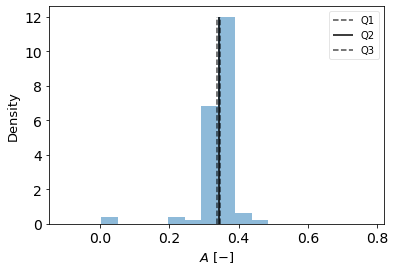

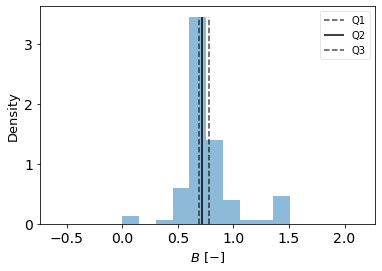

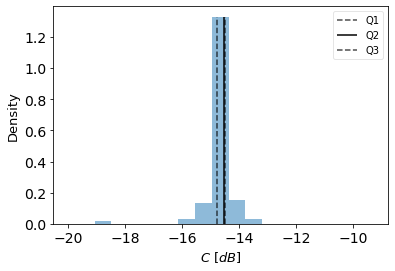

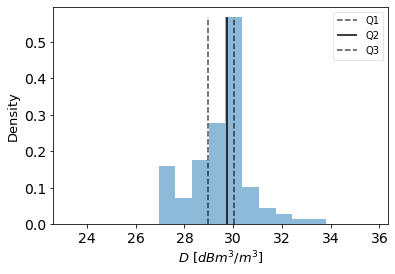

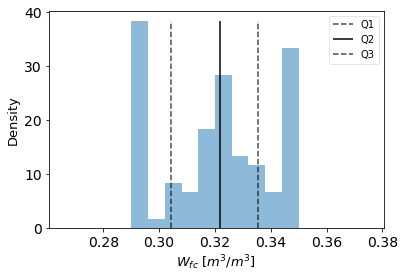

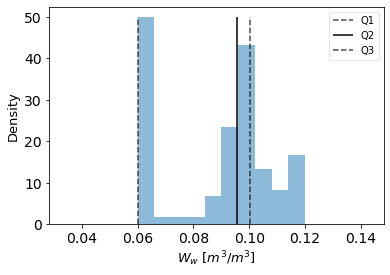

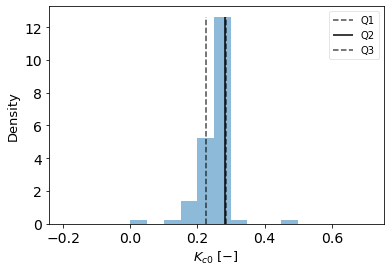

{'$A$': ['$[-]$', 'cal', [0, 5], 0.343, 0.005, [0.3440661793668602, 0.34911812272605747, 0.36892832816097215, 0.3455522870616489, 0.34243675258012723, 0.3446274322456994, 0.30317930002312116, 0.3375680156385627, 0.3436563448132778, 0.35137100755689527, 0.3229426620880762, 0.3343649235617579, 0.3386750115386277, 0.3666929119123851, 0.3417886797457612, 0.3246710091681252, 0.301488699414031, 0.0023475290016649235, 0.48580966923132873, 0.343790983848703, 0.3407473792087061, 0.39382513064813274, 0.3380511310958557, 0.34842181267693845, 0.34730710548911237, 0.37722103467123386, 0.3442418786320908, 0.3279136153311726, 0.3497637546254971, 0.3473969904999194, 0.30292596233758706, 0.3045293143232256, 0.338853040683734, 0.3490895945756174, 0.34570964871848386, 0.36329871390493573, 0.3847315890426854, 0.3447185263200044, 0.028809242466439663, 0.34090908708245016, 0.3417850236869917, 0.34298152747148214, 0.3512896800571699, 0.34357749566668516, 0.3327688777778906, 0.3335707008394919, 0.351724961967

In [170]:
PAR_dict, rowLabels = parameters_analysis(params, PAR, PARn_str, bounds, timestr, automate, nbins=10, opt_fit=False)

In [171]:
if automate: opt_save=True
else: opt_save = True if input('Save log with parameters\' values? [y/n]')=='y' else False

if opt_save:
    for label in PAR_dict:
        try:
            with open('Plot\\'+timestr+'_params.txt', 'w') as f: 
                f.write('PAR_dict={\n')
                for key, value in PAR_dict.items(): 
                    f.write("r'%s':%s,\n" % (key, value))
                f.write('}')
        except ValueError:
            pass

In [179]:
[PAR_dict[key][3] for key in PAR_dict]

[0.343, 0.716, -14.531, 29.753, 0.322, 0.096, 0.4, 0.282]

# Model output - plots sim VS obs for SM, sigma0

In [172]:
# Model validation and output

if not automate:
    if input('Do you want to plot with user-defined parameters\' values ? [y/n]')=='y':
        
        timestr = time.strftime("%y%m%d-%H%M%S"); print('Timestring: ', timestr)
        
        # PAR_tot = [PAR_dict[label][3] for label in PAR_dict]
        PAR_tot = [0.329, 0.56, -15, 30, 10, 0.32, 0.10, 0.3, 0.5]
        print(PAR_tot)
        WW,IRR,sigma0,KGE = IRR_WCM(PAR_tot, inputs, user_in)
    else: WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

else:
    PARn = [PAR_dict[label][3] for label in PAR_dict if label in PARn_str]
    WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

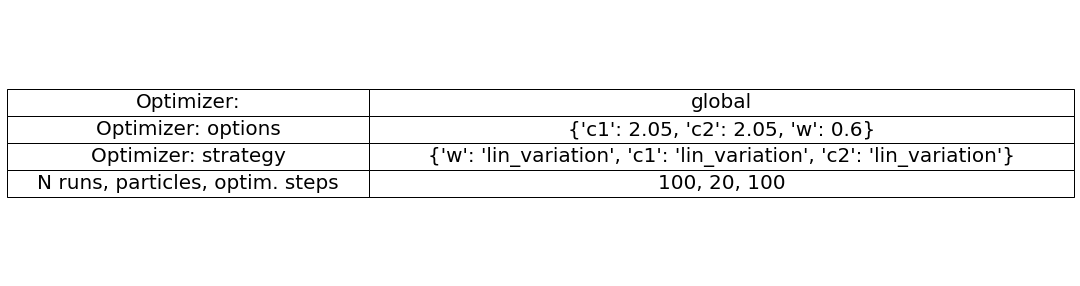

In [173]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
calib = 'sigma0' if opt_calib=='1' else 'sigma0+sm'
cellText = [
    # ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(len(params))+', '+str(n_particles)+', '+str(n_step)],
    # ['Time frequency', timing],
    # ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table_mach.png', dpi=100)
plt.show()

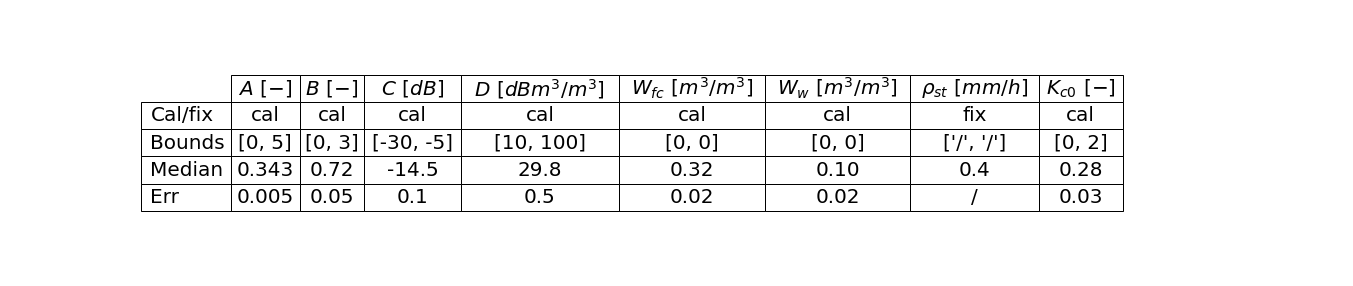

In [177]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

single_label = [label for label in PAR_dict][0]
cellText = [
    [
        significant_figures_str(PAR_dict[label][4],PAR_dict[label][i])[1] if type(PAR_dict[label][i])==np.float64
        else PAR_dict[label][i]
        for label in PAR_dict
    ] 
    for i in range(1,1+len(rowLabels))]

colLabels = [ f'{label} {PAR_dict[label][0]}' for label in PAR_dict ]
# rowLabels = [ 'Guess/fix value', 'Cal/fix', 'Bounds', 'Mean', 'St.dev.']

#---------------------------------
table = ax.table(cellText=cellText,
                  cellLoc='center', loc='center',
                  colLabels=colLabels,
                  rowLabels=rowLabels,
                )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.png')
plt.show()

## Triple plot SM+$\sigma^0$+inputs

In [1]:
#####################################################################
# Triple plot
#####################################################################
opt_show=True    
from scipy.signal import savgol_filter
        
if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(14, 12), sharex=True,dpi=300,)
filename = f'_triple_'+units+'_'+PAR_str_add
from scipy.signal import savgol_filter

plot_triple(fig, ax, times1=t_sat, data1=[VV, sigma0], data1_label=r'$\sigma^0$', 
            input1=veg, input1_label=opt_veg,
            times2=t, data2=[WW_obs, WW], data2_label=r'SM',
            input2=[], input2_label='',
            times3=t, data3=
            [P,
             IRR_obs,
             savgol_filter(EPOT, window_length=24, polyorder=1, mode='interp')],
            data3_label=['Rain', ' Irrigation', 'mean ET0'],
            user_input=[irri],
           )


name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.png')

if opt_show: plt.show()
plt.close()

NameError: name 'automate' is not defined

## Scatterplot

In [ ]:
if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'

plot_sim_vs_obs(sim=WW, obs=WW_obs, quantity='SM', um='[-]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

In [ ]:
if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'sigma0'

plot_sim_vs_obs(sim=sigma0, obs=VV, quantity=r'$\sigma^0$', um='[dB]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')

In [ ]:
PAR_dict